In [ ]:
!pip install transformers

# Importing Modules

In [ ]:
# Standard imports
import os
from pprint import pprint
import json
import pandas as pd
import numpy as np
from IPython.display import display
from tqdm import tqdm
from tqdm import trange
from colorama import Fore, Back, Style

# For plotting
import plotly.express as px
import plotly.graph_objects as go

# For Evaluation and model selection 
from sklearn.model_selection import *
from sklearn.metrics import *

# For model building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# For Transformer
import transformers
from transformers import AutoTokenizer, BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup


import warnings
warnings.filterwarnings("ignore")


# CONFIG

In [ ]:
cfg = {}
cfg['train_csv'] = "../input/commonlitreadabilityprize/train.csv"
cfg['test_csv'] = "../input/commonlitreadabilityprize/test.csv"
cfg['sample_sub'] = "../input/commonlitreadabilityprize/sample_submission.csv"
cfg['epochs'] = 20
cfg['max-len'] = 256
cfg['train_bs'] = 8
cfg['val_bs'] = 16
cfg['active-model'] = 'bert-base-uncased'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = torch.cuda.amp.GradScaler()

pprint(cfg)
print(DEVICE)
print(scaler)

# Loading train and test Data

In [ ]:
data_df = pd.read_csv(cfg['train_csv'])
data_df

In [ ]:
data_df['excerpt'].values[0]

## Distribution of Text length

In [ ]:
txt_len = []
for d in data_df.excerpt.values:
  txt_len.append(len(d.split(" ")))

fig = px.histogram(x = txt_len)
fig.update_layout(
    {
    'title' : 'Distribution of text length',
    'title_x' : 0.5,
    'xaxis_title' : 'Length of text'

    }
)

fig.update_xaxes(title_font_family="Arial")
fig.show()

From the chart we can see that most of the text's length are in the range of 170-180. So, we should choose our model accordingly

In [ ]:
# Creating a data loader class

class BERTDataset(Dataset):
    def __init__(self, txt, target):
        self.txt = txt
        self.target = target
        self.tokenizer = AutoTokenizer.from_pretrained(cfg['active-model'])
        self.max_len = cfg['max-len']
    
    def __len__(self):
        return len(self.txt)
    
    def __getitem__(self, idx):        
        # I have oberverd that some of the sentences have new line character
        txt = str(self.txt[idx]).replace("\n", "")
        
        # Inputs from hugging face tokenizer
        inputs = self.tokenizer.encode_plus(
            txt, 
            add_special_tokens = True,
            max_length = self.max_len,
            truncation = True,
            padding = 'max_length',
        )
        
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"] 
        
        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'target' : torch.tensor(self.target[idx], dtype = torch.float)
        }

# Building Model

In [ ]:
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        
        self.bert = BertModel.from_pretrained(cfg['active-model'])
        self.drop = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 10)
        self.out = nn.Linear(10, 1)
    
    def forward(self, ids, mask):
        outs= self.bert(
            ids, 
            attention_mask = mask,            
        )
        
        mean_pool = torch.mean(outs[0], 1)
        # max_pool = torch.max(outs[0], 1)
        # cat_ = torch.cat((mean_pool, max_pool), 1)
                
        # x = self.linear(cat_)
        x = self.linear(mean_pool)
        x = self.relu(x)
        x = self.drop(x)
        output = self.out(x)
        
        return output 

# Loss function : RMSE

In [ ]:
# Creating our loss function
def loss_fn(outputs, targets):
    outputs = outputs.squeeze(-1)
    mse = nn.MSELoss()
    rmse = torch.sqrt(mse(outputs, targets))
    return rmse

# Stratifying our dataset for train and validation

[By Abhishek Thakur](http://https://www.kaggle.com/abhishek)

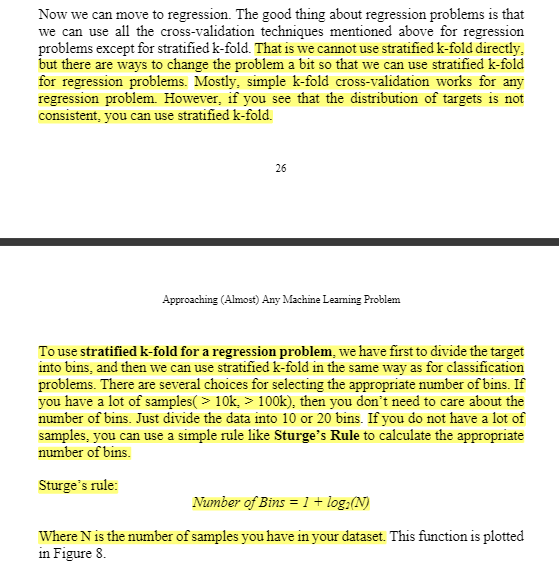         

In [ ]:
def create_folds(data, target="target", num_splits = 5): 
    data["kfold"] = -1 
    data = data.sample(frac=1).reset_index(drop=True)
    
    # Applying Sturg's rule to calculate the no. of bins for target
    num_bins = int(1 + np.log2(len(data))) 

    data.loc[:, "bins"] = pd.cut(data[target], bins=num_bins, labels=False) 
    
    kf = StratifiedKFold(n_splits=num_splits)
    
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)): 
        data.loc[v_, 'kfold'] = f
        
    data = data.drop(["bins"], axis = 1)         
    return data 

cv_data_df = create_folds(data_df, target = 'target', num_splits = 5)
cv_data_df.kfold.value_counts()

# Training and evaluation functions

In [ ]:
def start_train(model, dataLoader, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True

    allPreds = []; allTargets = []

    for d in dataLoader:
        losses = []
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            ids = d['ids'].to(DEVICE, non_blocking = True)
            mask = d['mask'].to(DEVICE, non_blocking = True)
            target = d['target'].to(DEVICE, non_blocking = True)

            preds = model(ids, mask)
            cur_loss = loss_fn(preds, target)

            losses.append(cur_loss.item())
            allPreds.append(preds.squeeze(-1).detach().cpu().numpy())
            allTargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(cur_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

    allPreds = np.concatenate(allPreds)
    allTargets = np.concatenate(allTargets)

    loss = np.mean(losses)

    return allPreds, loss

def validation(model, dataLoader):
    model.eval()

    allPreds = []; allTargets = []

    for d in dataLoader:
        losses = []

        with torch.no_grad():
            ids = d['ids'].to(DEVICE, non_blocking = True)
            mask = d['mask'].to(DEVICE, non_blocking = True)
            target = d['target'].to(DEVICE, non_blocking = True)

            preds = model(ids, mask)
            cur_loss = loss_fn(preds, target)

            losses.append(cur_loss.item())
            allPreds.append(preds.squeeze(-1).detach().cpu().numpy())
            allTargets.append(target.detach().squeeze(-1).cpu().numpy())


    allPreds = np.concatenate(allPreds)
    allTargets = np.concatenate(allTargets)

    loss = np.mean(losses)

    return allPreds, loss
        

# Training

In [ ]:
# Creating the training process
def run():
    
    # torch.cuda.empty_cache()
    for fold in range(5):
        print(Fore.GREEN)
        print("_ "*20, "\n")
        print(f"{' '*11}Current Fold : {fold}")
        print("_ "*20, "\n")

        train_df = cv_data_df.loc[cv_data_df.kfold != fold].reset_index(drop = True)
        val_df = cv_data_df.loc[cv_data_df.kfold == fold].reset_index(drop = True)

        # Building train and val dataloader
        train_dataset = BERTDataset(
            txt = train_df.excerpt.values,
            target = train_df.target.values,
        )

        val_dataset = BERTDataset(
            txt = val_df.excerpt.values,
            target = val_df.target.values,
        )

        train_data_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = cfg['train_bs'],
            num_workers = 4,
            shuffle = True,
            pin_memory = True
        )

        val_data_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size = cfg['val_bs'],
            num_workers = 4,
            shuffle = True,
            pin_memory = True
        )


        # Calling model
        model = BERTBaseUncased()
        model.to(DEVICE)
        LR = 2e-5
        optimizer = AdamW(model.parameters(),
                         LR,
                         betas = (0.9, 0.999),
                         weight_decay = 1e-2)


        train_steps = len(train_df)/cfg['train_bs']*cfg['epochs']
        num_steps = int(train_steps*0.1)

        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                   num_steps,
                                                   train_steps)

        train_losses = []; val_losses = []; best = 1e8

#         for epoch in trange(cfg['epochs'], bar_format="{l_bar}%s{bar:50}%s{r_bar}" % (Fore.CYAN, Fore.RESET), position = 0, leave = True):
        for epoch in range(cfg['epochs']):  
            print()
            print(Fore.YELLOW,"#"*40)
            print(Fore.YELLOW,"#"*10," EPOCH #",epoch+1," ","#"*15)
            print(Fore.YELLOW,"#"*40)
            print()
            
            trainPreds, trainloss = start_train(model,
                                          train_data_loader,
                                          optimizer,
                                          scheduler                                         
                                         )
            valPreds, valloss = validation(model,
                                          val_data_loader                                  
                                         )

            oldbest = best
            best = min(best, valloss)

            print(f" TrainLoss : {trainloss}")
            print(f" ValLoss : {valloss}")
            print(f" Best : {best}")

            if oldbest > best:
                model_state = {
                    'state_dict' : model.state_dict(),
                    'optimizer_dict' : optimizer.state_dict(),
                    'bestScore' : best
                }
                
                # Makes a folder to save our Model weights
                if not os.path.exists("./BestBERTBaseUncasedModels"):
                    os.mkdir("./BestBERTBaseUncasedModels")
                torch.save(model_state, f"./BestBERTBaseUncasedModels/model_{fold}.pth")
  
    

In [ ]:
run()

# Saving Model weight files

In [ ]:
!pip install kaggle

In [ ]:
!cp ../input/kaggle-token/kaggle_token.json ./
!mv ./kaggle_token.json ./kaggle.json

!ls -l ../../root
!cp ./kaggle.json ../../root/
!ls ../../root


!mkdir ../../root/.kaggle
!mv ../../root/kaggle.json ../../root/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets init -p ./BestBERTBaseUncasedModels

In [ ]:
!cat ./BestBERTBaseUncasedModels/dataset-metadata.json
with open("./BestBERTBaseUncasedModels/dataset-metadata.json", 'r+') as file_:
    meta_data = json.load(file_)
    meta_data['title'] = 'BestBERTBaseUncasedModelsCLRP'
    meta_data['id'] = 'hotsonhonet/BestBERTBaseUncasedModelsCLRP'
    file_.seek(0)        
    json.dump(meta_data, file_, indent=4)
    file_.truncate()
    
print(meta_data['title'], meta_data['id'])
print("\nAfter modification...\n")
!cat ./BestBERTBaseUncasedModels/dataset-metadata.json

In [ ]:
!kaggle datasets create -p ./BestBERTBaseUncasedModels